Remember, the raw data includes ordinary CitiBike trips but excludes an important wrinkle: rebalancing trips. These, too, need to be incorporated.

While doing the citibike weekly data generation I got around this problem by leaving the full dataset compilation step until I got to the geocoding. This was necessary because calculating full start and end times for a rebalanced trip is easiest to do by querying the Google API and getting back a trip estimate time.

However for the expanded scope of the viz envisioned since, this is too limiting. I need to actually be able to generate a single unified file *before* I start intensively processing trips and depositing them into my data store.

So what I decided I will do is check the trips to get rebalancing trips, as before, but this time query the Google API ahead of time, run those trips through their API, get the estimated trip time, discard the rest of the response (!), and generate and embed a new trip in the dataset using that trip time.

This is a little wasteful of resources, but strikes me as being simply too necessary to ignore. If I were to defer doing this until the final data processing and storage step, I would have to somehow account for those additional trips in my rate-limit monitoring, and somehow know how to encode them (hash them?). Doing it beforehand may waste a day's worth of API queries, but it will also make actually deaing with stuffing the data into the storage layer much easier.

An important caveat to consider is when a bike recieves a rebalancing trip, and that rebalancing trip is its end of day. For instance, suppose the raw data says that bike 112233 was ridden to station B on June 22, but then on June 23 it was ridden from station C. Then in between those two start and end times there was a rebalancing trip. But wait a minute, what if our standard estimation technique&mdash;interpolating midway&mdash;gives us a transfer time at 12:20-1:00 PM early June 23, after our visualization period has ended? What then?

As you can see, considering this limiting case is solvable by broadcasting against the bike trips remaining for the month, but I given the low volume of rebalancing trips in the first place I decided that honestly it's not worth the additional complexity. So the final visualization will have that one important caveat: bike transfers which occur during June 22nd but which occur after any rides on that day are not accounted for.

I will also calculate a unique id&mdash;this is useful for rate-limiting the data deposit script.

In [40]:
import pandas as pd
import os
import sys
from tqdm import tqdm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import citibike_trips

In [20]:
raw_data = pd.read_csv("../data/part_2/citibike_trips_on_june_22_2016.csv", index_col=0)

In [35]:
bike_ids = set(raw_data['bikeid'].values)
bike_trip_sets = [raw_data[raw_data['bikeid'] == bike_id].sort_values(by='starttime') for bike_id in bike_ids]

In [41]:
rebalancing_trip_tuples = []
for bike_trip_set in tqdm(bike_trip_sets):
    for i in range(0, len(bike_trip_set) - 2):
        possible_rebalanced_tuple = bike_trip_set.iloc[[i, i + 1]]
        if citibike_trips.RebalancingTrip.rebalanced(possible_rebalanced_tuple):
            rebalancing_trip_tuples.append(possible_rebalanced_tuple)

100%|██████████| 6497/6497 [00:41<00:00, 157.34it/s]


In [42]:
len(rebalancing_trip_tuples)

1077

In [53]:
time_estimates = []
client = citibike_trips.initialize_google_client(filename="../credentials/google_maps_api_key.json")
for rebalancing_trip_tuple in tqdm(rebalancing_trip_tuples):
    start = [rebalancing_trip_tuple.iloc[0]['end station latitude'],
             rebalancing_trip_tuple.iloc[0]['end station longitude']]
    end = [rebalancing_trip_tuple.iloc[0]['start station latitude'],
           rebalancing_trip_tuple.iloc[0]['start station longitude']]
    time_estimate = citibike_trips.RebalancingTrip.get_rebalancing_trip_path_time_estimate_tuple(
        start, end, client
    )[1]
    time_estimates.append(int(time_estimate) * 60)

100%|██████████| 1077/1077 [02:41<00:00,  6.86it/s]


Here are the sort times in seconds (maxes out at 33 minutes):

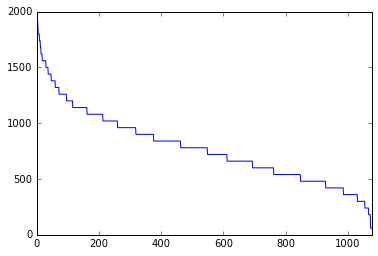

In [64]:
%matplotlib inline
pd.Series(sorted(time_estimates, reverse=True)).plot()

In [76]:
from datetime import timedelta
deltas_subframe = []

for t, delta_df in tqdm(zip(time_estimates, rebalancing_trip_tuples)):
    # The following code is ripped from the `citibike_trips` RebalancingTrip class definition.
    start_point = delta_df.iloc[0]
    end_point = delta_df.iloc[1]
    for point in [start_point, end_point]:
        for time in ['starttime', 'stoptime']:
            if isinstance(point[time], str):
                point[time] = pd.to_datetime(point[time], infer_datetime_format=True)
    midpoint_time = end_point['starttime'] + ((end_point['starttime'] - start_point['stoptime']) / 2)
    rebalancing_start_time = midpoint_time - timedelta(seconds=t / 2)
    rebalancing_end_time = midpoint_time + timedelta(seconds=t / 2)
    if rebalancing_start_time < start_point['stoptime']:
        rebalancing_start_time = start_point['stoptime']
    if rebalancing_end_time > end_point['starttime']:
        rebalancing_end_time = end_point['starttime']
    # Explicit casts are due to mongodb limitations, see BikeTrip above.
    attributes = {
        "tripduration": int(t),
        "start station id": int(start_point['end station id']),
        "end station id": int(end_point['start station id']),
        "start station name": start_point['end station name'],
        "end station name": end_point['start station name'],
        "bikeid": int(start_point["bikeid"]),
        "usertype": "Rebalancing",
        "birth year": 0,
        "gender": 3,
        "start station latitude": start_point['end station latitude'],
        "start station longitude": start_point['end station longitude'],
        "end station latitude": end_point['start station latitude'],
        "end station longitude": end_point['start station longitude'],
        "starttime": rebalancing_start_time.strftime("%Y-%d-%m %H:%M:%S"),
        "stoptime": rebalancing_end_time.strftime("%Y-%d-%m %H:%M:%S"),
    }
    deltas_subframe.append(attributes)
    # TODO: Next stage of the logic.

0it [00:00, ?it/s]/Users/Honors/anaconda/envs/citibike/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
1077it [06:07,  2.92it/s]


In [77]:
deltas_subframe[0]

{'bikeid': 14529,
 'birth year': 0,
 'end station id': 267,
 'end station latitude': 40.750977110000001,
 'end station longitude': -73.987654280000001,
 'end station name': 'Broadway & W 36 St',
 'gender': 3,
 'start station id': 546,
 'start station latitude': 40.744449209999999,
 'start station longitude': -73.983035290000004,
 'start station name': 'E 30 St & Park Ave S',
 'starttime': '2016-22-06 12:34:44',
 'stoptime': '2016-22-06 11:58:25',
 'tripduration': 1080,
 'usertype': 'Rebalancing'}

In [92]:
all_rebalancing_trips = pd.concat([pd.Series(df_proto) for df_proto in deltas_subframe], axis=1).T

In [93]:
all_rebalancing_trips

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
0,14529,0,267,40.751,-73.9877,Broadway & W 36 St,3,546,40.7444,-73.983,E 30 St & Park Ave S,2016-22-06 12:34:44,2016-22-06 11:58:25,1080,Rebalancing
1,14530,0,501,40.7442,-73.9712,FDR Drive & E 35 St,3,455,40.75,-73.9691,1 Ave & E 44 St,2016-22-06 13:54:48,2016-22-06 12:38:44,960,Rebalancing
2,14553,0,517,40.7516,-73.9779,Pershing Square South,3,492,40.7502,-73.9909,W 33 St & 7 Ave,2016-22-06 18:57:28,2016-22-06 18:20:47,660,Rebalancing
3,14591,0,480,40.7667,-73.9906,W 53 St & 10 Ave,3,520,40.7599,-73.9765,W 52 St & 5 Ave,2016-22-06 09:29:47,2016-22-06 09:18:25,420,Rebalancing
4,14601,0,3164,40.7771,-73.979,Columbus Ave & W 72 St,3,367,40.7583,-73.9707,E 53 St & Lexington Ave,2016-22-06 15:45:21,2016-22-06 13:35:52,1140,Rebalancing
5,14622,0,449,40.7646,-73.9879,W 52 St & 9 Ave,3,520,40.7599,-73.9765,W 52 St & 5 Ave,2016-22-06 10:40:08,2016-22-06 10:03:24,1020,Rebalancing
6,14635,0,520,40.7599,-73.9765,W 52 St & 5 Ave,3,514,40.7609,-74.0028,12 Ave & W 40 St,2016-22-06 23:09:23,2016-22-06 21:41:05,840,Rebalancing
7,14636,0,237,40.7305,-73.9867,E 11 St & 2 Ave,3,402,40.7403,-73.9896,Broadway & E 22 St,2016-22-06 15:37:08,2016-22-06 13:50:27,720,Rebalancing
8,14673,0,3137,40.7728,-73.9669,5 Ave & E 73 St,3,2006,40.7659,-73.9763,Central Park S & 6 Ave,2016-22-06 15:38:31,2016-22-06 13:24:53,420,Rebalancing
9,14675,0,237,40.7305,-73.9867,E 11 St & 2 Ave,3,402,40.7403,-73.9896,Broadway & E 22 St,2016-22-06 15:50:18,2016-22-06 14:03:28,300,Rebalancing


In [94]:
raw_data.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
1004842,785,6/22/2016 00:00:11,6/22/2016 00:13:17,334,W 20 St & 7 Ave,40.742388,-73.997262,450,W 49 St & 8 Ave,40.762272,-73.987882,25585,Subscriber,1978.0,1


In [95]:
all_rebalancing_trips.head(1)

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
0,14529,0,267,40.751,-73.9877,Broadway & W 36 St,3,546,40.7444,-73.983,E 30 St & Park Ave S,2016-22-06 12:34:44,2016-22-06 11:58:25,1080,Rebalancing


In [96]:
all_trips = pd.concat([raw_data, all_rebalancing_trips])

Inspect for consistency.

In [97]:
len(all_trips)

56826

In [100]:
all_trips.to_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)